<h1>Benchmarking: GM24385 Small Variant Caling</h1>

In this tutorial we will demonstrate how Oxford Nanopore Technologies performs benchmarking of small variant calling. The methods presented
are derived from best practices outlined by the Genome in a Bottle project. The tutorial is provided as an accompaniment to the
[Small variant calling with GM24385](https://nanoporetech.github.io/ont-open-datasets/gm24385_snp/) blogpost of the
Oxford Nanopore Technologies Open Data website.

The notebook will demonstrate the extent to which small variant calling can be achieved using recommended variant calling tools from Oxford Nanopore Technologies and third parties. We will examine the outputs of these workflows and show how to compare results to independently provided truth sets. The present notebook does not itself perform small variant calling.

Computational requirements for this tutorial include:

* Computer running the **EPI2ME Labs** notebook Server
* At least 16Gb RAM

## Small Variant calling with Medaka and DeepVariant

We will begin with a review of the [Small variant calling with GM24385](https://nanoporetech.github.io/ont-open-datasets/gm24385_snp/) blogpost which walks through the process to obtain accurate small variant calls from a 60-fold coverage dataset of the GIAB GM24385 sample. This sample was sequenced using a PromethION device with a modest 40kb library preparation.

### Recapitulation of variant calling

> ***The code snippets in this section are illustrate the variant calling process, they are not intended to be executed from the notebook environment.***

The first step of the blog post's demonstration is the download of the long-read data and a reference file. We repeat the commands used below for reference.

```
# Download alignments of reads to chr20
for ext in .bam .bam.bai; do
    aws s3 --no-sign-request cp s3://ont-open-data/gm24385_2020.09/analysis/r9.4.1/20200914_1354_6B_PAF27096_e7c9eae6/guppy_v4.0.11_r9.4.1_hac_prom/align_unfiltered/chr20/calls2ref${ext} PAF27096.chr20${ext}
    aws s3 --no-sign-request cp s3://ont-open-data/gm24385_2020.09/analysis/r9.4.1/20200914_1357_1-E11-H11_PAF27462_d3c9678e/guppy_v4.0.11_r9.4.1_hac_prom/align_unfiltered/chr20/calls2ref${ext} PAF27462.chr20${ext}
done

# merge alignment files
samtools merge chr20.bam PAF27096.chr20.bam PAF27462.chr20.bam
samtools index chr20.bam

# keep only primary alignments of reads
samtools view chr20.bam -F 2308 -@ 64 -b > chr20.primary.bam
samtools index chr20.primary.bam

# download reference sequence
for ext in .fasta .fasta.fai; do
    aws s3 --no-sign-request cp s3://ont-open-data/gm24385_2020.09/config/ref/GCA_000001405.15_GRCh38_no_alt_analysis_set${ext} .
done
```

The commands above can be copy and pasted, and run into any Linux environment.

The first step of variant calling from the provided alignment files is to run [medaka](https://github.com/nanoporetech/medaka):

```
# running medaka to generate candidates for DeepVariant
medaka_variant \
    -i chr20.primary.bam \
    -f GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta \
    -r chr20 -t 8 -P 0 -l
```

Medaka can be used as a variant caller in isolation, but for optimal results it can be used in tandem with [DeepVariant](https://github.com/google/deepvariant). In the blog post DeepVariant is used via a wrapping command-line script and a Docker container:


```
# download helper command-line program
wget https://gist.githubusercontent.com/cjw85/23d2b0675ec5a5c7fd4074456524c971/raw/c716c85639f047b9a9cff2079be2868bccb61659/run_deepvariant.sh
chmod +x run_deepvariant.sh

# run DeepVariant
./run_deepvariant.sh \
    -b medaka_variant/round_0_hap_mixed_phased.bam \
    -v medaka_variant/round_1.vcf \
    -r GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta \
    -o deepvariant -t 64
```

The useful output for our purposes is a single [Variant Call Format](https://en.wikipedia.org/wiki/Variant_Call_Format) file containing the called variants.

## Benchmarking small variant calls

> ***The remainder of the notebook contains executable code snippets to be run within the notebook***

To get started benchmarking a small variant callset, we will create a working directory:


In [1]:
from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'snp_benchmarking')

# create a work directory and move into it
tutorial_name = "snp_benchmarking"
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/snp_benchmarking


To demonstrate the benchmarking process for small variant calls we will use a VCF created through the process outlined above. This can be downloaded by running the following:

In [ ]:
prefix="https://ont-open-data.s3.amazonaws.com/gm24385_2020.09/extra_analyses/r9.4.1_smallvariant"

# fetch DeepVariant variants 
for ext in (".vcf.gz", ".vcf.gz.tbi"):
    !wget $prefix/deep_variant/deepvariant$ext
# and the medaka results given to DeepVariant
!wget -O medaka_candidates.vcf $prefix/medaka_variant/round_1.vcf
!bgzip -f medaka_candidates.vcf
!tabix -f medaka_candidates.vcf.gz
# fetch read alignments
for ext in (".bam", ".bam.bai"):
    !wget -O round_0_hap_mixed_phased$ext $prefix/medaka_variant/round_0_hap_mixed_phased_tutorial_region$ext
# finally fetch the reference sequence
for ext in (".fasta", ".fasta.fai"):
    !wget -O GCA_000001405.15_GRCh38_no_alt_analysis_set$ext $prefix/GCA_000001405.15_GRCh38_no_alt_analysis_set$ext

The above will download also a BAM-formatted alignment file which contains the sequencing reads, and the human reference to which the reads were aligned.

### Truth sets

To assess the veracity of the variant calling workflow we require a "truth set". For the GM24385 sample this is provided by the Genome In A Bottle project. The truth set variant calls have been derived and validated using multiple technologies. Together will variant calls are provided "high confidence" regions; these are regions where where variant calling and the implied DNA sequence of the genome is particularly well characterised. Outside of these regions we have less certainty over variant, and non-variant, loci. Full details are available in [Best practices for benchmarking germline small-variant calls in human genomes](https://www.nature.com/articles/s41587-019-0054-x).

The GIAB truth set, both variant calls and high-confidence regions can be downloaded using the following commands:

In [ ]:
# downloading truth variant data and confidence regions for GM24385
site = "https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/release/AshkenazimTrio/HG002_NA24385_son/NISTv4.1/GRCh38/"
basename = "HG002_GRCh38_1_22_v4.1_draft_benchmark"
for ext in (".bed", ".bed.gz", ".bed.gz.tbi", ".vcf.gz", ".vcf.gz.tbi"):
    !wget -O $basename$ext $site/$basename$ext

The truth variants are provided as a gzip-compressed VCF, whereas the high confidence regions are a gzip-compressed [BED](https://en.wikipedia.org/wiki/BED_(file_format)) file.

### Analysis with hap.py

The recommended method for analysing small variant calls with respect to a truthset is through the use of [hap.py](https://github.com/Illumina/hap.py). Comparison of a set of variant calls to a truthset would seem at first to be a rather
trivial affair: one must simply determined is a called variant is present or absent in the truth set, and vice-versa.
However as discussed in the GIAB best practices paper, the VCF specification allows for a single variant to be
expressed in a multitude of different ways. `hap.py` provides a way to overcome these issue and allows the robust comparison
of two VCF files. The `hap.py` [documentation](https://github.com/Illumina/hap.py#motivation) provides an overview of these considerations.

We will install `hap.py` into the EPI2MELabs notebook environment using the conda package manager. We use conda via the [mamba](https://github.com/mamba-org/mamba) software, which provides a fast reimplementation of the original conda suite of program.

In [ ]:
!. /opt/conda/etc/profile.d/conda.sh \
    && mamba create -q -p /opt/conda/envs/hap.py -y hap.py openblas rtg-tools

Having installed `hap.py` with the above command it is ready use with our GM24385 medaka-DeepVariant calls and the GIAB truth sets.
To perform part of its comparison work `hap.py` uses a second program `rtg vcfeval`, this second tool requires a conversion of the
human reference file downloaded above to an alternative format. `hap.py` can perform the conversion on-the-fly but since we will
run the program several times it is useful to perform the conversion once ahead of time.

To convert the `.fasta` formatted reference file to `rtg`'s `.sdf` format we run:

In [ ]:
reference = "GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta"
!rm -rf $reference".sdf"
!/opt/conda/envs/hap.py/share/rtg-tools-3.11-0/rtg format $reference -o $reference".sdf"

Let's now run `hap.py` in the most basic way possible:

In [ ]:
from multiprocessing import cpu_count
threads = cpu_count()

!cecho ok "Running hap.py with $threads threads"
!run hap.py \
    HG002_GRCh38_1_22_v4.1_draft_benchmark.vcf.gz \
    deepvariant.vcf.gz \
    -f HG002_GRCh38_1_22_v4.1_draft_benchmark.bed \
    -r GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta \
    --engine-vcfeval-template GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta.sdf \
    -o happy_out \
    --pass-only -l chr20 --engine=vcfeval \
    --threads=$threads
!cecho ok "hap.py execution finished"

At the end of its execution `hap.py` will have printed summary statistics concerning its comparison. These results are also available
within a text file which we can read with the `pandas` library:

In [10]:
import pandas as pd

def read_happy_summary(fname):
    df = pd.read_csv(fname)
    df = df[df['Filter'] == 'PASS'].set_index('Type')
    return df

df = read_happy_summary("happy_out.summary.csv")
display(df.transpose())

Type,INDEL,SNP
Filter,PASS,PASS
TRUTH.TOTAL,11271,71334
TRUTH.TP,6580,71104
TRUTH.FN,4691,230
QUERY.TOTAL,14114,117365
QUERY.FP,1429,194
QUERY.UNK,5945,46044
FP.gt,355,25
FP.al,625,117
METRIC.Recall,0.583799,0.996776


The table above contains a variety of interesting counts and statistics. A full discussion is again available in the `hap.py` [documentation](https://github.com/Illumina/hap.py/blob/master/doc/happy.md), here we will focus on just a few.

#### Interpretation of the results

With respect to a truth set the calling of variants in a genomic sample can be seen as a binary classification task: we have two classes of data, variants and non-variants. A standard method for summarizing this classification task is the measurement of the two quantities *precision* and *recall*, as summarized by the following [diagram](https://en.wikipedia.org/wiki/Precision_and_recall):

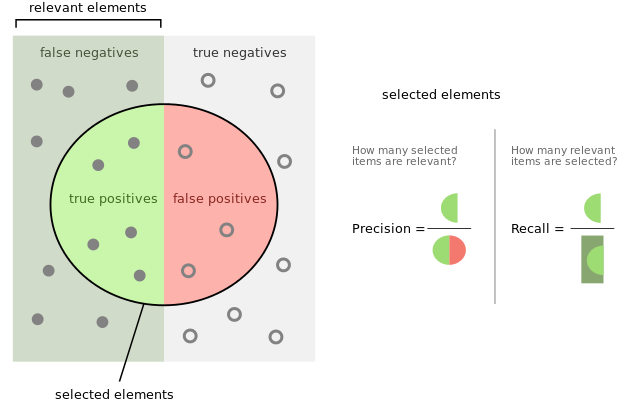

For our purposes the "relevant elements" are the variant loci and identities, while the remaining elements are locations in the genomic sample that contain the same sequence as the reference sequence. It is useful to note that neither *recall* nor *precision* take into account true negatives. This is the situation where a variant caller has correctly identified that the sample under consideration contains the same sequence as the reference. The metrics *recall* and *precision* thereby are sensitive only to loci identified as variants by the caller, and loci which are variant in the truthset. For the variant calling classification task we have around only 0.12% of locations in the genome containing a variant (equating to around Q30 on the [Phred](https://en.wikipedia.org/wiki/Phred_quality_score) scale). The numerical values of the two metrics are therefore lower than metrics which consider the total accuracy of sequencing: the correct identification of non-variants is not rewarded by the metrics.

We can make this comparison to sequence accuracy by approximately calculating the error rate of the sequence implied by the called variants:

In [11]:
import pandas as pd
import numpy as np

bed = pd.read_csv(
    'HG002_GRCh38_1_22_v4.1_draft_benchmark.bed',
    sep='\t', names=['chrom', 'start', 'stop'])
chr20 = bed[bed['chrom'] == 'chr20']
truth_len = sum(bed['stop'] - bed['start'])
errors = sum(df['TRUTH.FN'] + df['QUERY.FP'])
print(
    "Implied sequence accuray (PHRED SCALE): {:.2f}".format(
    -10 * np.log10(errors / truth_len)))

Implied sequence accuray (PHRED SCALE): 55.89


So we see that the even modestly high recall and precision numbers imply rather high sequencing quality. With these considerations out of the way, and focussing on *precision* and *recall* from the above table:

In [12]:
display(df[['METRIC.Recall', 'METRIC.Precision']].transpose())

Type,INDEL,SNP
METRIC.Recall,0.583799,0.996776
METRIC.Precision,0.825070,0.997280


We see that both precision and recall are high so the calling of single-nucleotide polymorphisms (substitutions of single bases) indicating
that the medaka-DeepVariant workflow can correctly identify the vast majority of variants in the truth set whilst maintaining a low false positive rate. It is important to maintain high precision (few false positive) as well as high recall (identification of variants) as doing otherwise can
confound post-calling analysis.

To illustrate this further, let's consider the case where a variant caller incorrectly identifies every genomic location as being a variant. The caller would have recovered every true variant from the truth set such that recall would be maximised, however precision would be extremely low due to the vast excess (>99%) of calls that are false positives. For this reason we introduce a third metric, the [F1-score](https://en.wikipedia.org/wiki/F-score), as the harmonic mean of precision and recall:

In [13]:
display(df[['METRIC.Recall', 'METRIC.Precision', 'METRIC.F1_Score']].transpose())

Type,INDEL,SNP
METRIC.Recall,0.583799,0.996776
METRIC.Precision,0.825070,0.997280
METRIC.F1_Score,0.683776,0.997028


We have now a motivation as to why the recall of INDEL (insertion and deletion) variants is somewhat low; this recall is the maximum that can be tolerated whilst maintaining relatively high precision. The accurate calling of INDEL variants is an ongoing area of research for nanopore sequencing.

### Results by genomic context

In the preceding section we have examined results for the areas of chromosome 20 as defined by the GIAB high-confidence regions. The GIAB [resources](https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/release/genome-stratifications/v2.0/GRCh38/) define also a range of so-called "*stratifications*": genomic regions with common or relevant properties.

Let us first create a `.bed` file which defines sub-regions of the high-confidence regions which are not repetitive elements. To accomplish this we can download a `.bed` file defining the repetitive regions and use `bedtools` to perform the intersection:

In [ ]:
import os
bedstore = "https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/release/genome-stratifications/v2.0/GRCh38"

def make_bed(infile, outfile):
    basename = os.path.basename(infile)
    unzipped = os.path.splitext(basename)[0]
    !cecho ok "Downloading data"
    !wget $bedstore/$infile
    !gunzip -f $basename
    !cecho ok "Running bedtools intersect"
    !bedtools intersect \
        -a HG002_GRCh38_1_22_v4.1_draft_benchmark.bed \
        -b $unzipped \
        > $outfile
    !cecho ok "Bedtools finished"
    
make_bed(
    "LowComplexity/GRCh38_notinAllTandemRepeatsandHomopolymers_slop5.bed.gz",
    "HG002_GRCh38_1_22_v4.1_draft_benchmark.norepeat.bed")

A second subset we can define are the regions which are determined to be segmental duplications. And finally a third set of sub-regions can
be defined as those considered to be regions of "*low mappability*". Again we can download a `.bed` file for each subset and intersect the regions:

In [ ]:
make_bed(
    "SegmentalDuplications/GRCh38_segdups.bed.gz",
    "HG002_GRCh38_1_22_v4.1_draft_benchmark.segdups.bed")
make_bed(
    "mappability/GRCh38_lowmappabilityall.bed.gz",
    "HG002_GRCh38_1_22_v4.1_draft_benchmark.lowmap.bed")

We can now run `hap.py` providing these stratifications, most of the command is the same as before we add simply an additional argument specifying the name of the stratifications and the corresponding `.bed` file:

In [ ]:
from multiprocessing import cpu_count
threads = cpu_count()

!cecho ok "Running hap.py with $threads threads"
!run hap.py \
    HG002_GRCh38_1_22_v4.1_draft_benchmark.vcf.gz \
    deepvariant.vcf.gz \
    -f HG002_GRCh38_1_22_v4.1_draft_benchmark.bed \
    -r GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta \
    --engine-vcfeval-template GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta.sdf \
    -o happy_out.strats \
    --pass-only -l chr20 --engine=vcfeval \
    --threads=$threads \
    --stratification-region low_complex:HG002_GRCh38_1_22_v4.1_draft_benchmark.norepeat.bed \
    --stratification-region seq_dups:HG002_GRCh38_1_22_v4.1_draft_benchmark.segdups.bed \
    --stratification-region low_map:HG002_GRCh38_1_22_v4.1_draft_benchmark.lowmap.bed
!cecho ok "hap.py execution finished"

To obtain the metrics for the new stratification regions we must read `hap.py`'s extended results file. This contains additional information
over the summary file, some which we will not examine here. To display a simplified table from the extended results file, run the following:

In [65]:
df = read_happy_summary("happy_out.strats.extended.csv")
df = df.loc[
    (df['Subtype'] == '*') & df['Subset'].map(lambda x: not 'TS' in x),
    ['Subset', 'METRIC.Recall', 'METRIC.Precision', 'METRIC.F1_Score']] \
    .rename(columns={'Subset':'Stratification'}) \
    .replace('*', 'all') \
    .reset_index()
display(df)

,Type,Stratification,METRIC.Recall,METRIC.Precision,METRIC.F1_Score
0,INDEL,all,0.583799,0.825070,0.683776
1,INDEL,low_map,0.810127,0.941606,0.870932
2,INDEL,no_repeat,0.935988,0.978219,0.956638
3,INDEL,seq_dups,0.814286,0.888000,0.849547
4,SNP,all,0.996776,0.997280,0.997028
5,SNP,low_map,0.992655,0.993385,0.993020
6,SNP,no_repeat,0.999036,0.999184,0.999110
7,SNP,seq_dups,0.979960,0.978088,0.979023


The "*all*" rows in the above are the results we obtained previously, with additional rows corresponding to the stratification regions separated again by INDEL and SNP variant types. We see that all results are improved when considering only low-complexity regions of the genome. Results are also improved in the low-mappability and segmental-duplication regions compared to the general case showing that it is regions containing, for example homopolymers, short tandem repeats, and other locally repetitive sequences where the variant caller is performing less well.

### Viewing alignments

In the preceding section we have shown how to calculate aggregate measures for the veracity of variant calls. To assess the benchmark calls in more detail we will study some single variant calls with the help of a genome viewer.

The EPI2MELabs environment notebook environment has the power to access the popular [Integrative Genomics Viewer](https://github.com/igvteam/igv.js) for viewing genomics data. Run the code-cell below to show the viewer:

In [ ]:
# create a genome viewer
import os
from igv_jupyterlab import IGV

fasta = 'epi2melabs/snp_benchmarking/GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta'
genome = IGV.create_genome(
    name="Human (GRCh38/hg38)",
    fasta_url=f"files/{fasta}",
    index_url=f"files/{fasta}.fai")

bam_track = IGV.create_track(
    name="reads", fmt="bam",
    url="files/epi2melabs/snp_benchmarking/round_0_hap_mixed_phased.bam",
    index_url="files/epi2melabs/snp_benchmarking/round_0_hap_mixed_phased.bam.bai",
    colorBy='strand')

dv_track = IGV.create_track(
    name="DeepVariant", fmt="vcf",
    url="files/epi2melabs/snp_benchmarking/deepvariant.vcf.gz",
    index_url="files/epi2melabs/snp_benchmarking/deepvariant.vcf.gz.tbi",
    autoHeight=True, minHeight=40, maxHeight=40)

med_track = IGV.create_track(
    name="Medaka", fmt="vcf",
    url="files/epi2melabs/snp_benchmarking/medaka_candidates.vcf.gz",
    index_url="files/epi2melabs/snp_benchmarking/medaka_candidates.vcf.gz.tbi",
    autoHeight=True, minHeight=40, maxHeight=40)

truth_track = IGV.create_track(
    name="Truthset", fmt="vcf",
    url="files/epi2melabs/snp_benchmarking/HG002_GRCh38_1_22_v4.1_draft_benchmark.vcf.gz",
    index_url="files/epi2melabs/snp_benchmarking/HG002_GRCh38_1_22_v4.1_draft_benchmark.vcf.gz.tbi",
    autoHeight=True, minHeight=40, maxHeight=40)

bed_track = IGV.create_track(
    name="Confidence region", fmt="bed",
    type="annotation",
    url="files/epi2melabs/snp_benchmarking/HG002_GRCh38_1_22_v4.1_draft_benchmark.bed",
    displayMode='COLLAPSED', autoHeight=True, minHeight=30, maxHeight=30)

#chr20:32,243,285-32,249,300
igv = IGV(
    genome=genome, tracks=[bed_track, truth_track, dv_track, med_track, bam_track],
    locus="chr20:32,243,500-32,248,200")
igv

The viewer will have been launched and display the region `chr20:32,243,500-32,248,200`. The labels on the left-hand side indicate the various "tracks" that have been loaded. In order these are:

* **Confidence region**: the GIAB confidence regions. Blue shading indicates genomic locations within the region, gaps in the blue bar indicate unconfident regions.
* **Truthset**: the GIAB truth variants. The top line of dark blue markings indicates location of variant record within the VCF file, the lower line of variously coloured markings indicate positions where the sample has been determined to be different from the reference. Light grey: no call, cyan: homozygous non-reference, dark blue: heterozygous, darker grey (not generally used here): reference calls.
* **DeepVariant**: the DeepVariant calls from nanopore data.
* **Medaka**: the variant calls from medaka (with multi-nucleotide substitutions split to independent single-nucleotide substitutions).
* **Reads**: The sequencing reads coloured by strand (pink: +, purple: -), with an accompanying coverage histogram. The histogram is mostly grey except for loci with significant number of reads with bases different from the reference.

The viewer is fully interactive, users can zoom, pan, click items for more information and save the view to an SVG file. The viewer can also be manipulated with code, lets zoom in to the region on the left-hand size:

In [48]:
igv.locus = "chr20:32,244,000-32,244,200"

Executing the above cell will have caused the view to zoom to the region.

#### Case Study 1: a simple substitution

Clicking the left-most blue and cyan rectangles on the Truthset track will reveal the windows:

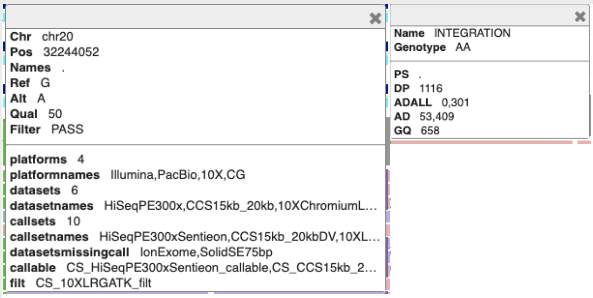

detailing the variant. We see that the truthset contains an alternative base A (from the reference G), but that the variant call (genotype) for the current sample is A,A - a homozygous non-reference call. Both the DeepVariant and Medaka calls agree with this assessment.

#### Case study 2: A correctly filtered insertion

Also in this region we see that medaka has created a candidate insertion variant. We can create a new viewer and zoom in to see the putative variant:

In [ ]:
locus = "chr20:32,244,080-32,244,110"
case2 = IGV(
    genome=genome, tracks=[bed_track, truth_track, dv_track, med_track, bam_track],
    locus=locus)
display(case2)

We can extract the details for this variant using pysam (the IGV viewer does not display details for small insertions):

In [ ]:
import pysam

with pysam.VariantFile('medaka_candidates.vcf.gz', 'r') as vcf:
    for rec in vcf.fetch("chr20", 32244080, 32244110):
        print(rec)

The medaka VCF file marks the variant as low quality, it was subsequently not passed to DeepVariant for assessment. By comparison to the truthset we see that this is the correct decision for this locus.

#### Case study 3: an ambiguous homopolymer

Let us zoom to a different locus:

In [ ]:
locus = "chr20:32,246,271-32,246,309"
case3 = IGV(
    genome=genome, tracks=[bed_track, truth_track, dv_track, med_track, bam_track],
    locus=locus)
display(case3)

The truthset indicates a deletion of 7 As is possible here: the reference allele is `CAAAAAAA` with and alternative of `C`. The truthset genotype is C, C, so the sample contains the homozygous alternative. The medaka variant call proposes and accepts a deletion of 6 As (`CAAAAAA > C`); with this information DeepVariant lists the genotype as "NoCall", with a light grey rectangle in the viewer and a "RefCall" entry in the VCF file:

In [ ]:
import pysam

with pysam.VariantFile('deepvariant.vcf.gz', 'r') as vcf:
    for rec in vcf.fetch("chr20", 32246271, 32246309):
        print(rec)

The accurate calling of cases like the above, where homopolymers from the reference are truncated or extended is an ongoing area of research. The fact that the generally less-powerful medaka algorithm can establish a near perfect call, where DeepVariant cannot, shows that perhaps more accurate results can be found by a more holistic method.

#### Case study 4: A call outside the confidence region

As a final study case we will examine a variant call proposed by medaka and confirmed by DeepVariant that lies outside the confidence region:

In [ ]:
case4 = IGV(
    genome=genome, tracks=[bed_track, truth_track, dv_track, med_track, bam_track],
    locus="chr20:32,225,976-32,226,273")

display(case4)
print("\nVariant details from VCF file:")
with pysam.VariantFile('deepvariant.vcf.gz', 'r') as vcf:
    for rec in vcf.fetch("chr20", 32225976, 32226273):
        print(rec)

In the confidence region track we see that the GIAB confidence region has a gap at this locus of approximately 100 bases. Examining the reference sequence in this region we can see why perhaps the GIAB dataset is not confident: the sequence is of low complexity, rich in T, with repetitive elements. Nevertheless the evidence for a variant at this position is strong in the long reads spanning the region.

From the VCF file we see that the variant is called and a homozygous insertion of a `T` with high confidence (`QUAL=48.9`) by DeepVariant. As is evident from the reads  displayed in the viewer (and detailed in the VCF), greater than 70% of the reads are concordant with this calls.

## Summary

In this tutorial we have demonstrated how Oxford Nanopore Technologies performs benchmarking of small variant calling. The methods presented
follow those outlined by the Genome in a Bottle project. The tutorial is provided as an accompaniment to the
[Small variant calling with GM24385](https://nanoporetech.github.io/ont-open-datasets/gm24385_snp/) blogpost of the
Oxford Nanopore Technologies Open Data website.

We have shown the tools used by Oxford Nanopore Technologies to assess the veracity of variant callers and to aid the development of new and improved methodologies.